In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from keras.layers import GRU
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Mounting google Drive to import data
path = '/content/drive/MyDrive/Assignment_2_data/dataset'
data_path=os.path.join(path, "X")
label_path=os.path.join(path, "Y")

In [5]:
x_train = np.load('/content/drive/MyDrive/Assignment_2_data/x_train.npy')
x_test = np.load('/content/drive/MyDrive/Assignment_2_data/x_test.npy')
y_train = np.load('/content/drive/MyDrive/Assignment_2_data/y_train.npy')
y_test = np.load('/content/drive/MyDrive/Assignment_2_data/y_test.npy')

In [20]:
input_shape= (64, 1000, 1)
CRNNmodel = models.Sequential()
CRNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CRNNmodel.add(layers.MaxPooling2D((2, 2)))
CRNNmodel.add(layers.Dropout(0.2))
CRNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CRNNmodel.add(layers.MaxPooling2D((2, 2)))
CRNNmodel.add(layers.Dropout(0.2))
CRNNmodel.add(layers.Conv2D(128, (3, 3), activation='relu'))
CRNNmodel.add(BatchNormalization())
CRNNmodel.add(layers.MaxPooling2D((2, 2)))
CRNNmodel.add(layers.Dropout(0.2))
CRNNmodel.add(layers.Conv2D(256, (3, 3), activation='relu'))
CRNNmodel.add(BatchNormalization())
CRNNmodel.add(layers.Dropout(0.2))
CRNNmodel.add(tf.keras.layers.Reshape((484,256)))
CRNNmodel.add(GRU(32))
CRNNmodel.add(layers.Dropout(0.2))
CRNNmodel.add(layers.Flatten())
CRNNmodel.add(layers.Dense(256, activation='relu'))
CRNNmodel.add(layers.Dense(10, activation='sigmoid'))

In [21]:
CRNNmodel.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 62, 998, 32)       320       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 31, 499, 32)      0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 31, 499, 32)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 29, 497, 64)       18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 248, 64)      0         
 g2D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 14, 248, 64)     

In [23]:
CRNNmodel.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=["accuracy", ])

In [24]:
from keras.callbacks import ModelCheckpoint
filepath = '/content/drive/MyDrive/Assignment_2_data/CRNN_best.epoch-loss.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [25]:
history=CRNNmodel.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=126, verbose = 1, callbacks=[checkpoint])

Epoch 1/126
313/313 [==============================] - ETA: 0s - loss: 0.3543 - accuracy: 0.1118
Epoch 1: val_accuracy improved from -inf to 0.04800, saving model to /content/drive/MyDrive/Assignment_2_data/CRNN_best.epoch-loss.hdf5
313/313 [==============================] - 46s 105ms/step - loss: 0.3543 - accuracy: 0.1118 - val_loss: 0.5524 - val_accuracy: 0.0480
Epoch 2/126
312/313 [============================>.] - ETA: 0s - loss: 0.3193 - accuracy: 0.1126
Epoch 2: val_accuracy did not improve from 0.04800
313/313 [==============================] - 30s 96ms/step - loss: 0.3193 - accuracy: 0.1125 - val_loss: 0.3957 - val_accuracy: 0.0480
Epoch 3/126
313/313 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.1131
Epoch 3: val_accuracy improved from 0.04800 to 0.04950, saving model to /content/drive/MyDrive/Assignment_2_data/CRNN_best.epoch-loss.hdf5
313/313 [==============================] - 31s 98ms/step - loss: 0.3039 - accuracy: 0.1131 - val_loss: 0.3536 - val_

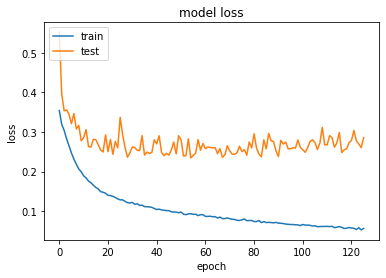

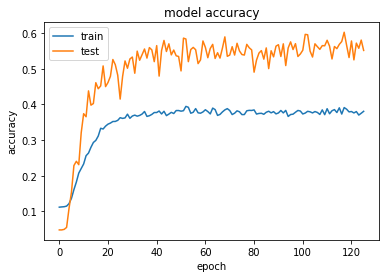

In [26]:
from matplotlib import pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
import keras
CRNNmodel=keras.models.load_model('/content/drive/MyDrive/Assignment_2_data/CRNN_best.epoch-loss.hdf5')
accuracy = CRNNmodel.evaluate(x_test, y_test)
pred=CRNNmodel.predict(x_test)

63/63 [==============================] - 2s 28ms/step


In [13]:
def modify_predictions(y_pred, th):
  for arr in y_pred:
    i = 0
    for z in arr:
      if(z>=th):
        arr[i] = 1
      else:
        arr[i] = 0
      i = i+1
  return y_pred

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, modify_predictions(pred, 0.5)))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       392
           1       0.84      0.90      0.87       436
           2       0.92      0.82      0.87       274
           3       0.73      0.74      0.74       444
           4       0.79      0.67      0.72       306
           5       0.85      0.80      0.82       221
           6       0.89      0.65      0.75       130
           7       0.85      0.65      0.74       143
           8       0.78      0.97      0.87      1246
           9       0.73      0.66      0.69       151

   micro avg       0.81      0.85      0.83      3743
   macro avg       0.83      0.78      0.80      3743
weighted avg       0.81      0.85      0.83      3743
 samples avg       0.83      0.87      0.83      3743



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
